# Implement VGG-16 Net

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms

class VGGlayer(nn.Module):
  def __init__(self, in_channels: int, out_channels: int, max_pool = False, activated = True):
    super(VGGlayer, self).__init__()
    self.activated = activated
    self.max_pool = max_pool
    self.convolution = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

  def forward(self, x):
    # Convolution - activation - pooling
    x = self.convolution(x)

    if self.activated:
      activation = nn.ReLU()
      x = activation(x)


    if self.max_pool:
      pooling = nn.MaxPool2d(kernel_size=2, stride=2)
      x = pooling(x)

    return x


class VGG16(nn.Module):
    def __init__(self, in_channels: int = 3, num_classes: int = 1000):
      super(VGG16, self).__init__()

      self.conv_features = nn.Sequential(
        VGGlayer(in_channels, 64),
        VGGlayer(64, 64, True),
        VGGlayer(64, 128),
        VGGlayer(128, 128, True),
        VGGlayer(128, 256),
        VGGlayer(256, 256),
        VGGlayer(256, 256, True),
        VGGlayer(256, 512),
        VGGlayer(512, 512),
        VGGlayer(512, 512, True),
        VGGlayer(512, 512),
        VGGlayer(512, 512),
        VGGlayer(512, 512, True),
      )

      self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

      self.classifier = nn.Sequential(
        nn.Linear(512 * 7 * 7, 4096),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(4096, num_classes),
        # nn.Softmax()
      )

    def forward(self, x):
      x = self.conv_features(x)
      x = self.avgpool(x)
      x = x.view(x.shape[0], -1)
      x = self.classifier(x)
      return x

# Forward Pass Debug
If it can process random data, then you're mostly alright :D

In [2]:
import numpy as np

net = VGG16()
num_params = sum([np.prod(p.shape) for p in net.parameters()])
print(f"Number of parameters : {num_params}")
print("-"*50)

# Test on ImageNet-like shaped data

X = torch.rand((8, 3, 224, 224))
print('Output shape for ImageNet:', net(X).shape)

Number of parameters : 121576232
--------------------------------------------------
Output shape for ImageNet: torch.Size([8, 1000])


In [3]:
# Test on CIFAR-like shaped data

net = VGG16(num_classes=10)

X = torch.rand((8, 3, 32, 32))
print('Output shape for CIFAR-10:', net(X).shape)

Output shape for CIFAR-10: torch.Size([8, 10])


# Let's train on CIFAR-10

In [4]:
import torchvision
import torchvision.transforms as transforms

mean = (0.4913997551666284, 0.48215855929893703, 0.4465309133731618)
std  = (0.24703225141799082, 0.24348516474564, 0.26158783926049628)

transform = transforms.Compose(
  [transforms.ToTensor(),
  transforms.Normalize(mean, std)]
)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:13<00:00, 12.2MB/s]


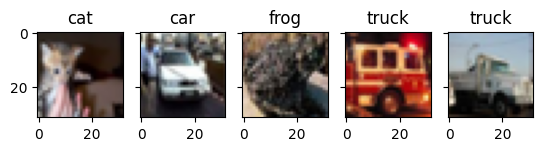

In [5]:
import matplotlib.pyplot as plt

# get some random training images
n_imgs = 5
images, labels = next(iter(trainloader))
images, labels = images[:n_imgs], labels[:n_imgs]

# print(images.shape)

fig, ax = plt.subplots(1, n_imgs, sharey=True)

for i in range(n_imgs):
  # denormalize
  img = images[i] * torch.tensor(std).reshape(-1, 1, 1) + torch.tensor(mean).reshape(-1, 1, 1)
  ax[i].imshow(img.permute(1, 2, 0))
  ax[i].set_title(classes[labels[i]])

plt.show()

In [6]:
if torch.backends.mps.is_available(): device = torch.device("mps")
elif torch.cuda.is_available(): device = torch.device("cuda:0")
else: assert False, "Cannot find neither Apple Silicon nor NVIDIA GPU"

net = VGG16(num_classes=10).to(device)

# Nothing works w/o proper initialization
def initialize_weights(model):
  for m in model.modules():
    if isinstance(m, nn.Conv2d):
      nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
      if m.bias is not None:
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
      nn.init.constant_(m.weight, 1)
      nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
      nn.init.normal_(m.weight, 0, 0.01)
      nn.init.constant_(m.bias, 0)

initialize_weights(net)
crit = nn.CrossEntropyLoss()
opt = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
epochs = 5
print(f"You\'re running this code on a {device} gpu.")

You're running this code on a cuda:0 gpu.


In [ ]:
from datetime import datetime
from IPython.display import Image
from tqdm.notebook import tqdm
from IPython.display import clear_output
from time import sleep
import matplotlib.pyplot as plt


losses = []

now = datetime.now()
train_name = f'{now.hour}:{now.minute}:{now.second}/'
for e in range(epochs):
  pbar = tqdm(total=len(trainloader), desc=f'Epoch {e} - 0%')
  for i, (x, y) in enumerate(trainloader):
    x, y = x.to(device), y.to(device)
    y_pred = net(x)
    loss = crit(y_pred, y)

    opt.zero_grad()
    loss.backward()
    losses.append(loss.item())

    opt.step()
    pbar.update(1)
    pbar.set_description(f'Epoch {e + 1} - {round(i/len(trainloader) * 100)}% -- loss {loss.item():.2f}')

  with torch.no_grad():
    corr = 0
    for x, y in testloader:
      x, y = x.to(device), y.to(device)
      y_pred = net(x)
      corr += (torch.max(y_pred, 1)[1] == y).sum()
  print(f"Accuracy for epoch {e + 1}: {corr / len(testset) * 100} %")

end = datetime.now() - now
print(f"Total training time is : {end}")

Epoch 0 - 0%:   0%|          | 0/782 [00:00<?, ?it/s]

Accuracy for epoch 1: 48.61000061035156 %


Epoch 1 - 0%:   0%|          | 0/782 [00:00<?, ?it/s]

Accuracy for epoch 2: 61.209999084472656 %


Epoch 2 - 0%:   0%|          | 0/782 [00:00<?, ?it/s]

Accuracy for epoch 3: 70.6500015258789 %


Epoch 3 - 0%:   0%|          | 0/782 [00:00<?, ?it/s]

Accuracy for epoch 4: 73.17999267578125 %


Epoch 4 - 0%:   0%|          | 0/782 [00:00<?, ?it/s]

Accuracy for epoch 5: 78.20999908447266 %
Total training time is : 0:03:58.858529


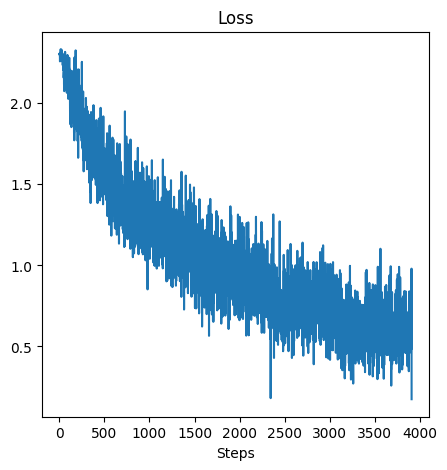

In [8]:
# Let's look at the loss
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(losses)
ax.set_title("Loss")
ax.set_xlabel("Steps")

plt.show()

# Testing Inference

Ref vs pred: tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1]) - tensor([3, 8, 8, 8, 6, 6, 1, 6, 3, 9])


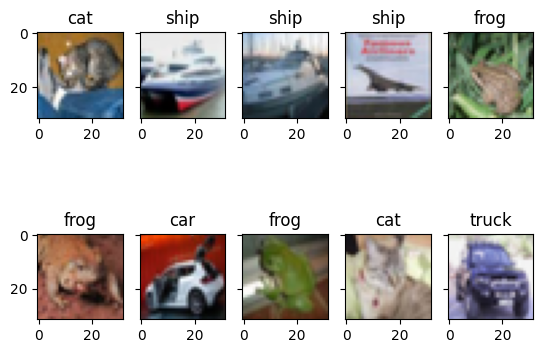

In [47]:
import matplotlib.pyplot as plt

IMGS_NUM = 10

test_imgs, ref_labels = next(iter(testloader))
test_imgs, ref_labels = test_imgs[:IMGS_NUM], ref_labels[:IMGS_NUM]

with torch.no_grad():
  test_imgs = test_imgs.to(device)
  y_pred = net(test_imgs)
  test_imgs, y_pred = test_imgs.cpu(), y_pred.cpu()

  print(f'Ref vs pred: {ref_labels} - {torch.max(y_pred, 1)[1]}')

  ROWS = IMGS_NUM//2
  fig, ax = plt.subplots(2, ROWS, sharey=True)
  for i in range(IMGS_NUM):
    img = test_imgs[i] * torch.tensor(std).reshape(-1, 1, 1) + torch.tensor(mean).reshape(-1, 1, 1)
    ax[i//ROWS][i%ROWS].imshow(img.permute(1, 2, 0))
    ax[i//ROWS][i%ROWS].set_title(classes[torch.max(y_pred, 1)[1][i]]) # Display predicted class

plt.show()